In [48]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('classic')

In [2]:
y = np.array([0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0])
t = np.array([0,0,1,0,0,0,0,0,0,0])

In [3]:
# 오차제곱합 (sum of squares for error. SSE)
def sum_squares_error(y, t) :
    return 0.5 * np.sum((y-t)**2)

In [4]:
sum_squares_error(y,t)

0.09750000000000003

In [5]:
# 교차 엔트로피 오차(cross entoropy error, CEE)
def cross_entropy_error(y,t) :
    # log 에 0이 들어가 값이 무한대가 되는 것을 방지
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

In [6]:
cross_entropy_error(y,t)

0.510825457099338

## 미니배치 학습
### 데이터 중 샘플을 뽑아 손실 함수를 계산하는 것을 미니배치 학습이라 한다.

In [7]:
import sys, os
sys.path.append(os.pardir)
from dataset.mnist import load_mnist

(X_train, y_train), (X_test, y_test) = load_mnist(normalize=True, one_hot_label=True)

In [8]:
def cross_entropy_error(y, t) :
    if y.ndim == 1 :
        t = t.reshape(1, -1)
        y = y.reshape(1, -1)
        
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + 1e-7)) / batch_size

# 미분

### 수치미분을 통한 편미분

In [9]:
def numerical_diff(f, x) :
    # 너무 적은 수로 두면 rounding error 가 발생할 수 있다.
    h = 1e-4
    # 정방 차분보다 중앙 차분이 근사로 인한 오차를 줄인다.
    return (f(x+h) - f(x-h)) / (2*h)

### 기울기

In [10]:
def numerical_gradient(f, x) :
    h = 1e-4
    grad = np.zeros_like(x)
    
    for idx in range(x.size) :
        tmp_val = x[idx]
        
        # numpy 배열에 값을 할당할 경우 자료형을 주의하자
        x[idx] = tmp_val + h
        fxh1 = f(x)
    
        x[idx] = tmp_val - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
        
    return grad

In [11]:
def function(x) :
    return x[0]**2 + x[1]**2

# numpy 는 자료형이 있는 배열이므로 값을 할당할 때 자료형이 다르면 형변환을 거친다.
# numpy 끼리 연산 시에는 numpy 가 자동으로 형변환을 고려하므로 이는 놓치기 쉽다.
# 따라서 기울기 연산과 같은 실수 연산 시에는 numpy를 float 으로 할당하는 것이 좋다.

x = np.array([3.0,4.0])
print(numerical_gradient(function, x))

[6. 8.]


# 경사하강법


In [12]:
def gradient_descent(f, init_x, lr=0.01, step_num=100) :
    x = init_x
    
    for _ in range(step_num) :
        grad = numerical_gradient(f,x)
        x -= lr * grad
        
    return x

In [13]:
init_x = np.array([-3.0, 4.0])
gradient_descent(function, init_x, lr=0.1)

array([-6.11110793e-10,  8.14814391e-10])

In [26]:
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

class simpleNet :
    def __init__(self) :
        self.W = np.random.randn(2,3)
        
    def predict(self, x) :
        return np.dot(x, self.W)
    
    def loss(self, x, t) :
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)
        
        return loss

In [27]:
net = simpleNet()
print("무작위 가중치 : \n", net.W)

x = np.array([0.6, 0.9])
p = net.predict(x)
print("무작위 가중치에 대한 학습 : ", p)
np.argmax(p)

무작위 가중치 : 
 [[-0.75097486 -0.60452739 -0.0484014 ]
 [-0.67901063 -1.7175672  -0.5577083 ]]
무작위 가중치에 대한 학습 :  [-1.06169448 -1.90852691 -0.53097831]


2

In [28]:
t = np.array([0,0,1])
net.loss(x, t)

0.6099716738250609

In [29]:
def f(W) :
    return net.loss(x,t)

dW = numerical_gradient(f, net.W)
print(dW)

[[ 0.1917594   0.08222086 -0.27398025]
 [ 0.28763909  0.12333129 -0.41097038]]


# 학습 알고리즘 구현하기

## 1. 미니배치
### 훈련 데이터 중 일부를 무작위로 가져온다.
<br>

## 2. 기울기 산출
### 미니배치로 가져온 데이터로 가충치 매개변수의 기울기를 구한다.
<br>

## 3. 매개변수 갱신
### 가충치 매개변수를 기울기 방향으로 아주 조금 갱신한다. 1번으로 돌아가 반복한다.
---

## 2층 신경망 클래스 구현하기.

In [44]:
import sys, os
sys.path.append(os.pardir)
from common.functions import *
from common.gradient import numerical_gradient

class TwoLayerNet :
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01) :
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def predict(self, x) :
        W1,W2 = self.params['W1'], self.params['W2']
        b1,b2 = self.params['b1'], self.params['b2']
        
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
    
    def loss(self, x, t) :
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t) :
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def gradient(self, x, t) :
        loss_W = lambda W : self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    
    # 오차역전파를 활용한 기울기 하강법
    def gradient_c(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        dz1 = np.dot(dy, W2.T)
        da1 = sigmoid_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)

        return grads

In [51]:
(X_train, y_train), (X_test, y_test) = load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []
train_acc_list = []
test_acc_list = []

iters_num = 10_000
train_size = X_train.shape[0]
batch_size = 100
learning_rate = 0.1

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num) :
    batch_mask = np.random.choice(train_size, batch_size)
    X_batch = X_train[batch_mask]
    y_batch = y_train[batch_mask]
    
    grad = network.gradient_c(X_batch, y_batch)
    
    for key in ['W1','b1','W2','b2'] :
        network.params[key] -= learning_rate * grad[key]
        
    loss = network.loss(X_batch, y_batch)
    train_loss_list.append(loss)
    
    if i % 100 == 0 :
        train_acc = network.accuracy(X_train, y_train)
        test_acc = network.accuracy(X_test, y_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

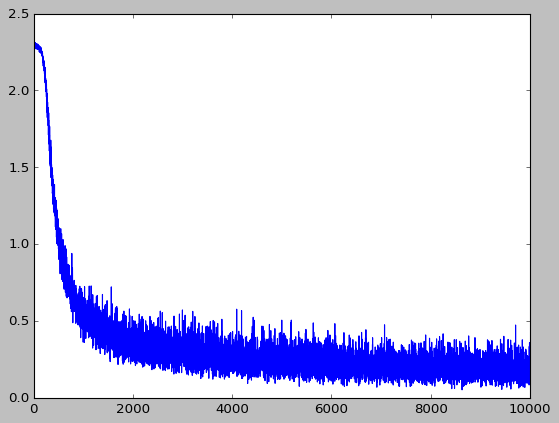

In [50]:

# 손실함수
plt.plot(train_loss_list)

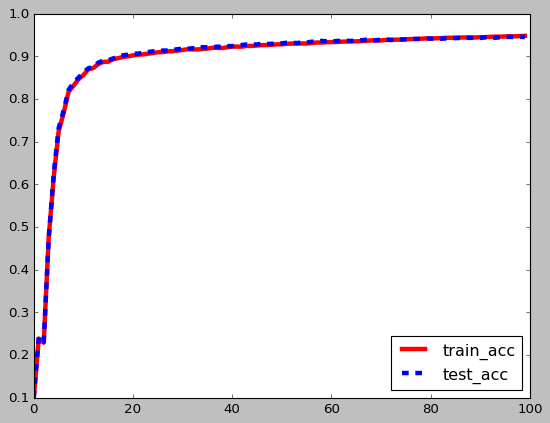

In [56]:
# 훈련 데이터와 테스트 데이터의 정확도
plt.plot(train_acc_list, label='train_acc', lw='4', c='r')
plt.plot(test_acc_list, label='test_acc', lw='4', c='b', ls='--')
plt.legend(loc='best')
plt.show()